** IMPORTANT NOTE- I prefered to perform this project on your local machine via using your preferable IDE not on google colab, if you don't have pro version then otherwise Google colab pro is good option.**

**This project Developed an autoencoder-based deep learning model in TensorFlow and OpenCV to convert grayscale images to color, Trained on a labeled kaggle landscape dataset**

***Import necessary libraries***

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
# [1]. this section is used to delete the dataset, if you are using Google Colab.
import shutil

# Replace 'folder_path' with the path of the folder to delete
folder_path = '/content/landscape_images'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder {folder_path} and its contents have been deleted.")
else:
    print("The folder does not exist.")


The folder does not exist.


In [ ]:
!pip install kaggle

***Getting landscape image data,resizing them and appending in array***

To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [ ]:
# [2]. In this section you need to have kaggle token,
#      so first create the token, then upload it in content
import os
# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [ ]:
# [3]. This section is used gor downloading the kaggle dataset in form of zip file.
# Download the dataset as a zip file
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 99% 189M/192M [00:00<00:00, 790MB/s] 
100% 192M/192M [00:00<00:00, 811MB/s]


In [ ]:
import zipfile

# Extract the contents of the zip file
with zipfile.ZipFile("landscape-image-colorization.zip", "r") as zip_ref:
    zip_ref.extractall("landscape_images")

In [ ]:
# [4]. This section is used to give path to the extracted dataset.
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/landscape_images/landscape Images/color'  #r"C:\Users\student\Projects\landscape Images\color"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '55_GT.png':
        break
    else:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/content/landscape_images/landscape Images/gray' #r"C:\Users\student\Projects\landscape Images\gray"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '55_hazy.png':
        break
     else:
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

100%|██████████| 7129/7129 [00:05<00:00, 1238.23it/s]


***Plotting Color image and it's corresponding grayscale image***

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.show()

***Plotting image pair***

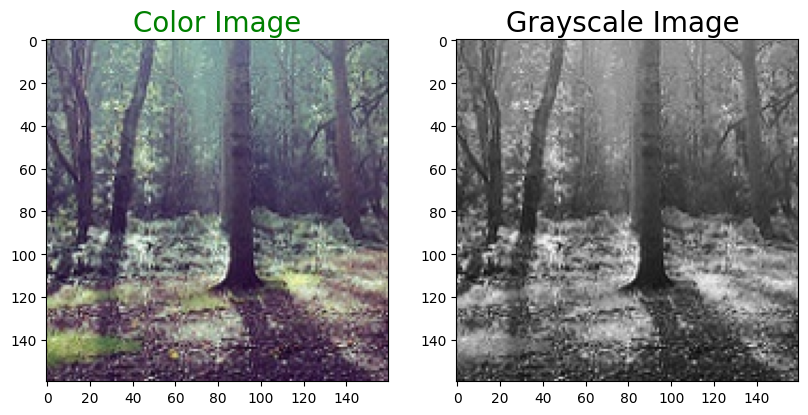

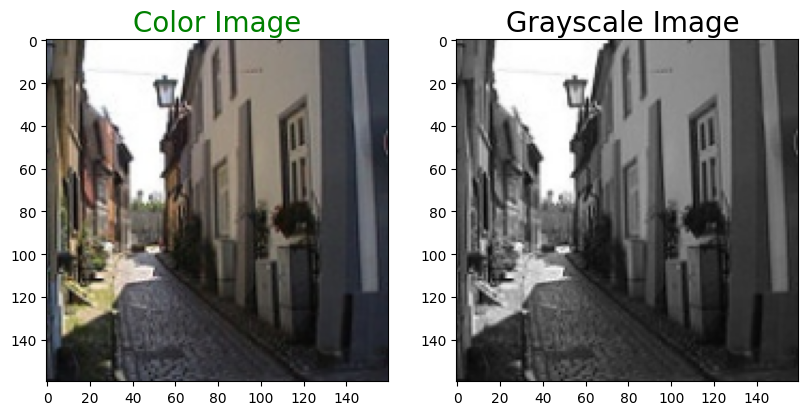

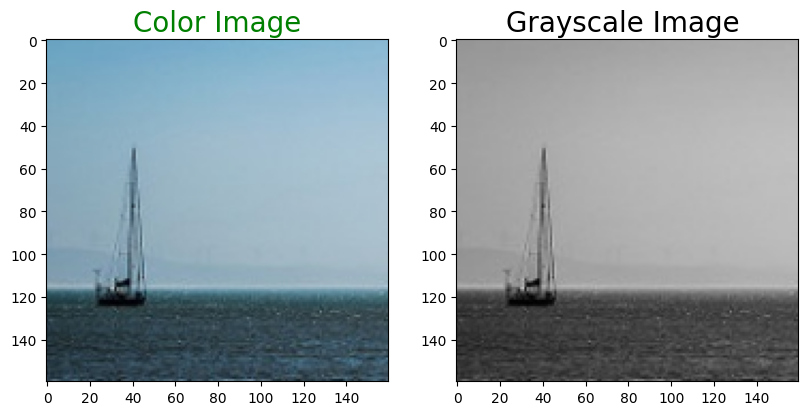

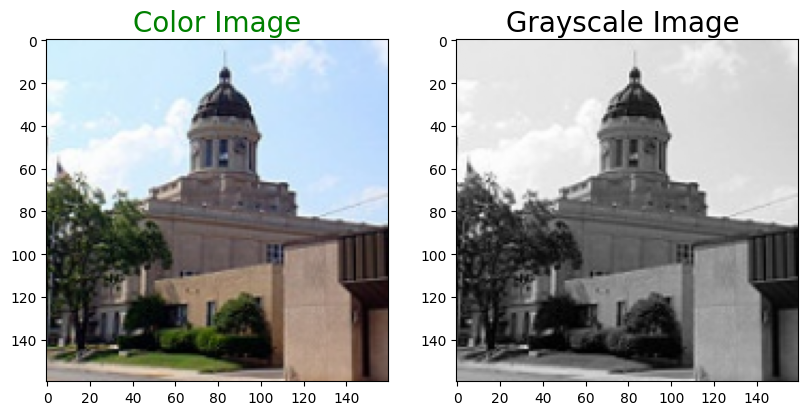

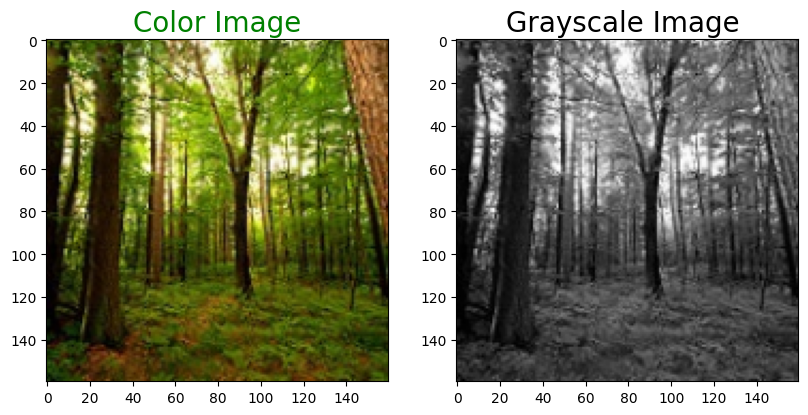

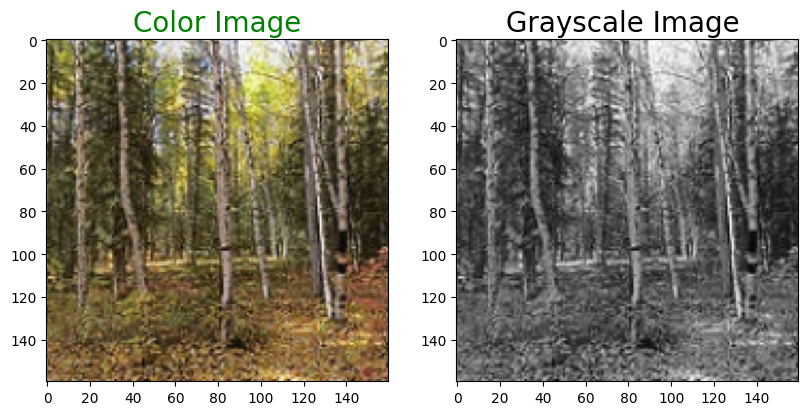

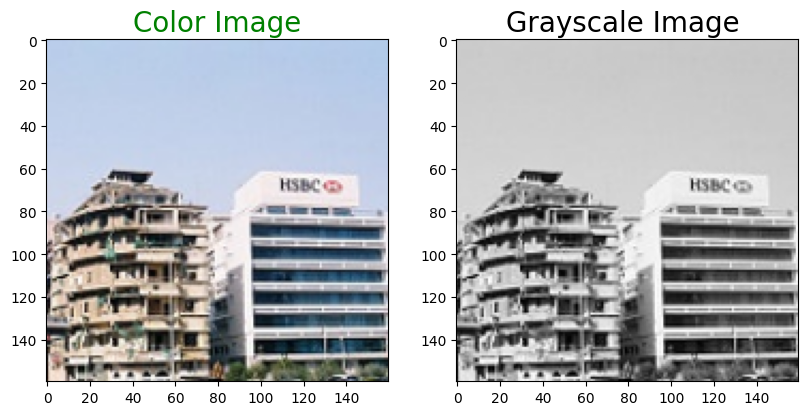

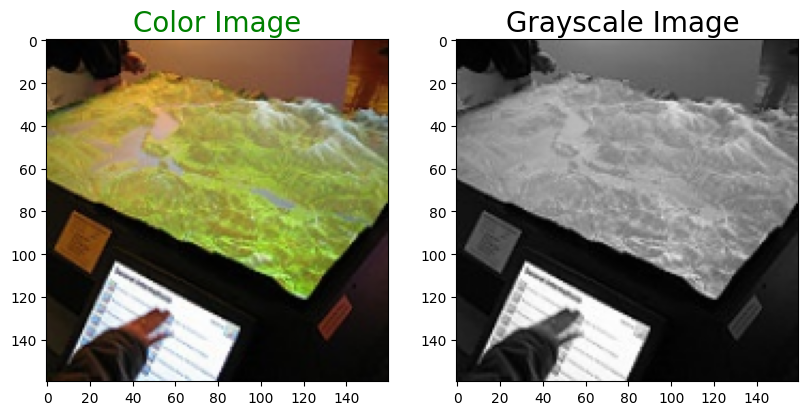

In [ ]:
for i in range(300,308):
     plot_images(color_img[i],gray_img[i])

***Slicing and reshaping***

Out of 7129 images I have sliced them to two part. train images consist 5129 images while test images contains 2000 images. After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [ ]:
train_gray_image = gray_img[:5129]
train_color_image = color_img[:5129]

test_gray_image = gray_img[2000:]
test_color_image = color_img[2000:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5129, 160, 160, 3)
Test color image shape (5129, 160, 160, 3)


***Defining our model***

Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling. Similary, Decoder layer of our model consist of transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder. Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers. Check U_Net architecture for better understanding......

In [ ]:
# [5]. This section is used to create the base for performing downsampling and upsampling.
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
# Assuming 'gray_img' is a grayscale image of shape (160, 160, 1)
import numpy as np

gray_img = np.expand_dims(gray_img, axis=-1)  # Ensure it's (160, 160, 1)
color_img = np.concatenate([gray_img, gray_img, gray_img], axis=-1)  # Convert to (160, 160, 3)

In [ ]:
# [6]. Defining convolutional layer for downsampling and upsampaling
def model():
    inputs = layers.Input(shape=[160,160,3])
    d1 = down(64, (3,3), False)(inputs)  # Reduce filters
    d2 = down(64, (3,3), False)(d1)
    d3 = down(128, (3,3), True)(d2)
    d4 = down(256, (3,3), True)(d3)

    d5 = down(256, (3,3), True)(d4)  # Reduced complexity

    # Upsampling
    u1 = up(256, (3,3), False)(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(128, (3,3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(64, (3,3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(64, (3,3), False)(u3)
    u4 = layers.concatenate([u4, d1])
    u5 = up(3, (3,3), False)(u4)
    u5 = layers.concatenate([u5, inputs])
    output = layers.Conv2D(3, (2,2), strides=1, padding='same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
#model.summary()
for layer in model.layers:
    print(layer.name, layer.output.shape)

input_layer (None, 160, 160, 3)
sequential (None, 80, 80, 64)
sequential_1 (None, 40, 40, 64)
sequential_2 (None, 20, 20, 128)
sequential_3 (None, 10, 10, 256)
sequential_4 (None, 5, 5, 256)
sequential_5 (None, 10, 10, 256)
concatenate (None, 10, 10, 512)
sequential_6 (None, 20, 20, 128)
concatenate_1 (None, 20, 20, 256)
sequential_7 (None, 40, 40, 64)
concatenate_2 (None, 40, 40, 128)
sequential_8 (None, 80, 80, 64)
concatenate_3 (None, 80, 80, 128)
sequential_9 (None, 160, 160, 3)
concatenate_4 (None, 160, 160, 6)
conv2d_5 (None, 160, 160, 3)


***Fitting our model***

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])
model.fit(train_g, train_c, epochs = 50,batch_size = 16) #,verbose = 0

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - acc: 0.2973 - loss: 0.1171
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - acc: 0.4211 - loss: 0.0639
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - acc: 0.4514 - loss: 0.0574
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - acc: 0.4711 - loss: 0.0521
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - acc: 0.4812 - loss: 0.0498
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.4715 - loss: 0.0496
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - acc: 0.4645 - loss: 0.0481
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - acc: 0.4845 - loss: 0.0473
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - acc: 0.5043 - loss: 0.0452
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - acc: 0.4937 - loss: 0.0463
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - acc: 0.5101 - loss: 0.0445
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - acc: 0.5056 - loss: 0.0441
Epoch 13/50
1

In [ ]:
model.evaluate(test_gray_image,test_color_image) #[0.041192106902599335, 0.6158594489097595]

25/25 [==============================] - 3s 105ms/step - loss: 0.0331 - acc: 0.6731


[0.03307477384805679, 0.6730849742889404]

In [ ]:
# [7]. To perform Important metrices related to Computer Vision concept,
#      this metrices are neccesary when you are making Image related project on
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

for i in range(100):
    predicted = model.predict(test_gray_image[i].reshape(1, 160, 160, 3)).reshape(160, 160, 3)
    true_image = test_color_image[i]
    psnr_value = psnr(true_image, predicted)
    # Explicitly set win_size to a smaller odd value
    # Assuming your pixel values are in the range [0, 1]
    data_range = 1.0  # Or 255 if your data is in the range [0, 255]
    ssim_value = ssim(true_image, predicted, multichannel=True, win_size=3, data_range=data_range)
    print(f"Image {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.3f}")

    # Calculate average PSNR and SSIM
avg_psnr = np.mean(psnr_value)
avg_ssim = np.mean(ssim_value)

print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.3f}")

1/1 [==============================] - 0s 213ms/step
Image 1 - PSNR: 25.90, SSIM: 0.875
1/1 [==============================] - 0s 37ms/step
Image 2 - PSNR: 31.75, SSIM: 0.843
1/1 [==============================] - 0s 37ms/step
Image 3 - PSNR: 29.52, SSIM: 0.941
1/1 [==============================] - 0s 38ms/step
Image 4 - PSNR: 30.32, SSIM: 0.818
1/1 [==============================] - 0s 35ms/step
Image 5 - PSNR: 27.46, SSIM: 0.924
1/1 [==============================] - 0s 39ms/step
Image 6 - PSNR: 27.39, SSIM: 0.927
1/1 [==============================] - 0s 33ms/step
Image 7 - PSNR: 30.38, SSIM: 0.943
1/1 [==============================] - 0s 36ms/step
Image 8 - PSNR: 23.30, SSIM: 0.868
1/1 [==============================] - 0s 36ms/step
Image 9 - PSNR: 29.64, SSIM: 0.939
1/1 [==============================] - 0s 34ms/step
Image 10 - PSNR: 26.56, SSIM: 0.911
1/1 [==============================] - 0s 33ms/step
Image 11 - PSNR: 29.21, SSIM: 0.925
1/1 [==============================] - 0

## **Using plots**

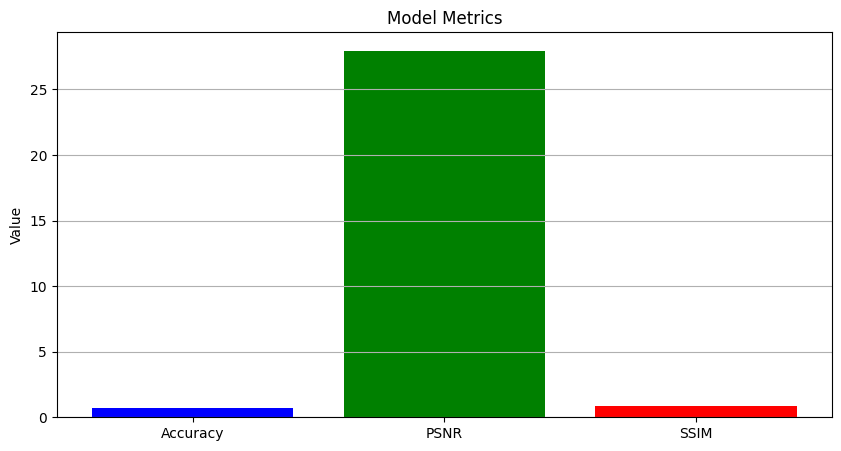

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
epochs = range(1, 51)  # Assuming 50 epochs
# Replace these with your actual recorded values from model training
# If you have only single values for these metrics, plotting them against epochs doesn't make sense.
# Consider plotting them as bar charts or single points instead.
accuracy_values = 0.6731
psnr_values = 27.96
ssim_values = 0.873

# If you intend to plot the trend over epochs, you would need lists of values, one for each epoch.
# For example:
# accuracy_values = [0.65 + i * 0.001 for i in range(50)]
# psnr_values = [27.0 + 0.01 * i for i in range(50)]
# ssim_values = [0.85 + 0.0001 * i for i in range(50)]


# To plot the single values, you can use a bar chart:

plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'PSNR', 'SSIM'], [accuracy_values, psnr_values, ssim_values], color=['blue', 'green', 'red'])
plt.title('Model Metrics')
plt.ylabel('Value')
plt.grid(axis='y')
plt.show()

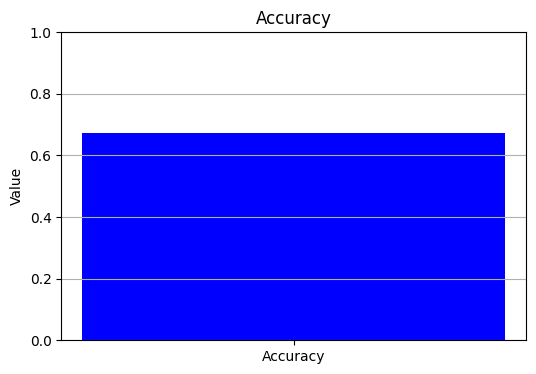

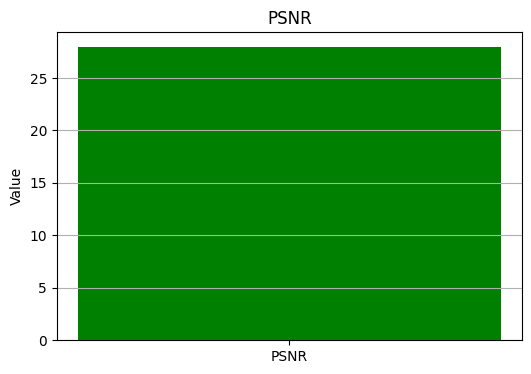

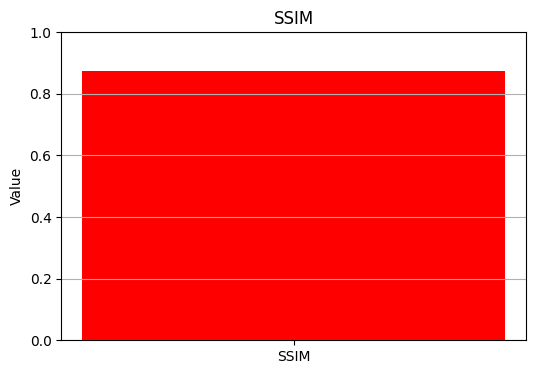

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual recorded values from model training
accuracy_values = 0.6731
psnr_values = 27.96
ssim_values = 0.873

# Plot Accuracy
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.bar(['Accuracy'], [accuracy_values], color='blue')
plt.title('Accuracy')
plt.ylabel('Value')
plt.grid(axis='y')
plt.ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.show()

# Plot PSNR
plt.figure(figsize=(6, 4))
plt.bar(['PSNR'], [psnr_values], color='green')
plt.title('PSNR')
plt.ylabel('Value')
plt.grid(axis='y')
# plt.ylim(0, 50) # Optionally set y-axis limits for PSNR
plt.show()

# Plot SSIM
plt.figure(figsize=(6, 4))
plt.bar(['SSIM'], [ssim_values], color='red')
plt.title('SSIM')
plt.ylabel('Value')
plt.grid(axis='y')
plt.ylim(0, 1)  # Set y-axis limits for SSIM (0 to 1)
plt.show()

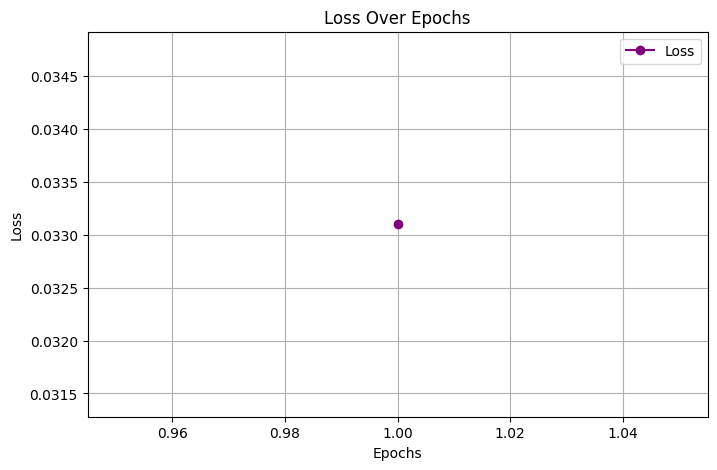

In [ ]:
loss_values = [0.0331]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', color='purple', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

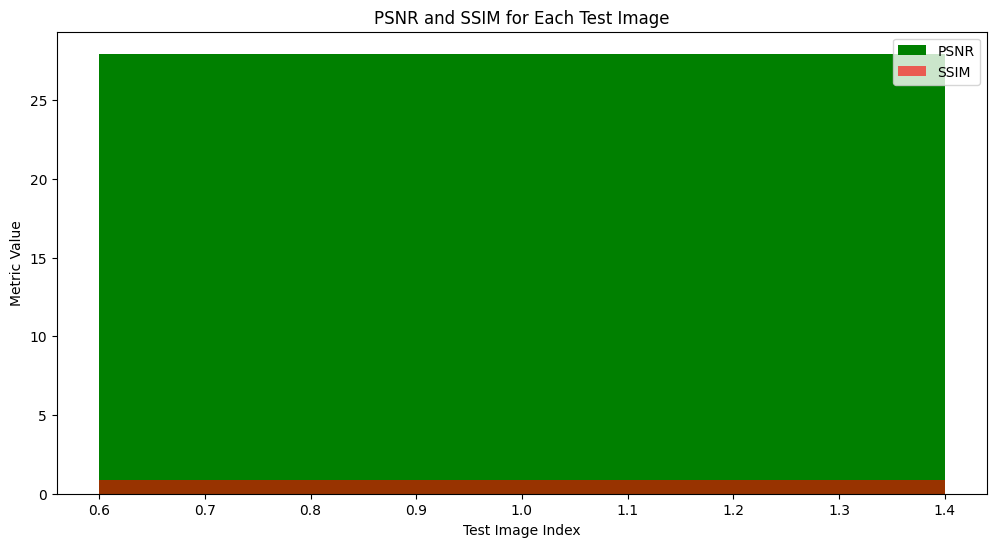

In [ ]:
import numpy as np
psnr_values = [27.96]
ssim_values = [0.873]
test_images = np.arange(1, len(psnr_values) + 1)  # Replace with your test image indices
plt.figure(figsize=(12, 6))
plt.bar(test_images, psnr_values, color='green', label='PSNR')
plt.bar(test_images, ssim_values, color='red', alpha=0.6, label='SSIM')
plt.title('PSNR and SSIM for Each Test Image')
plt.xlabel('Test Image Index')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
   

***plotting colorized image along with grayscale and color image***

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


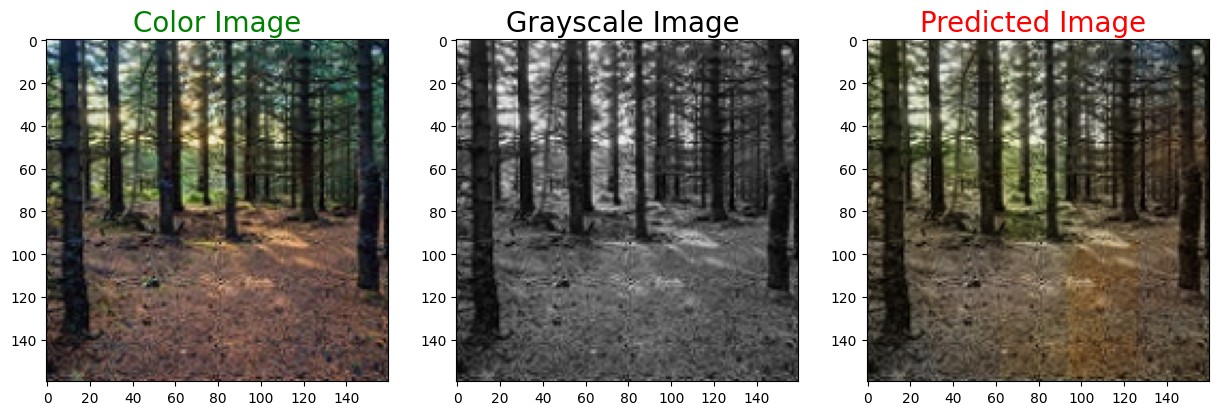

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


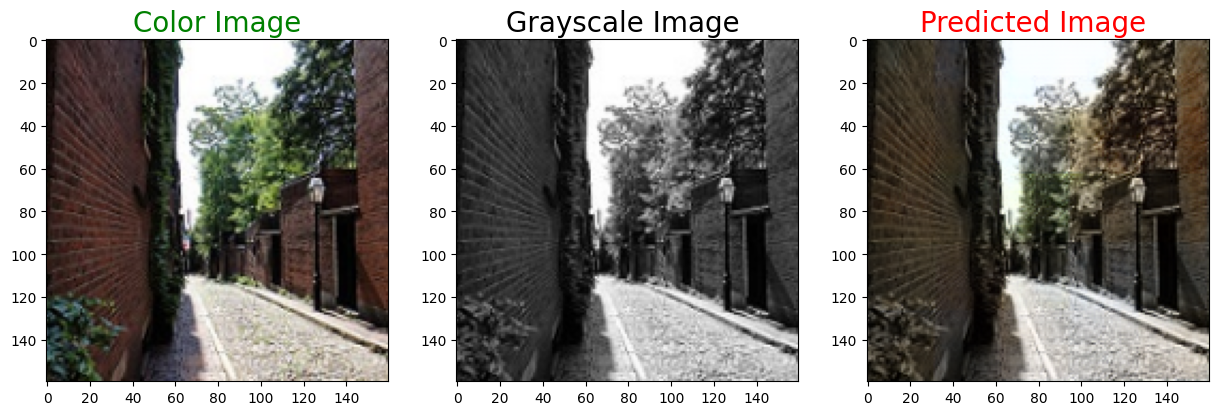

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


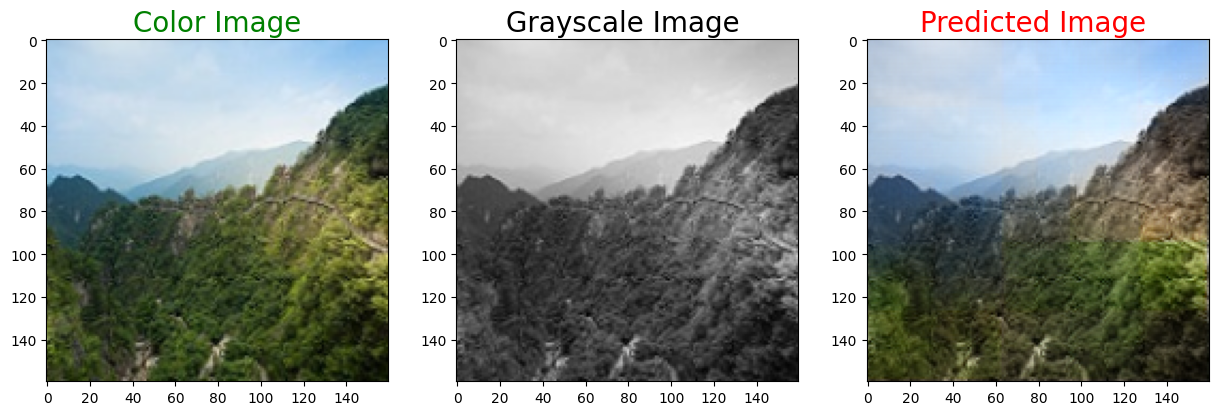

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


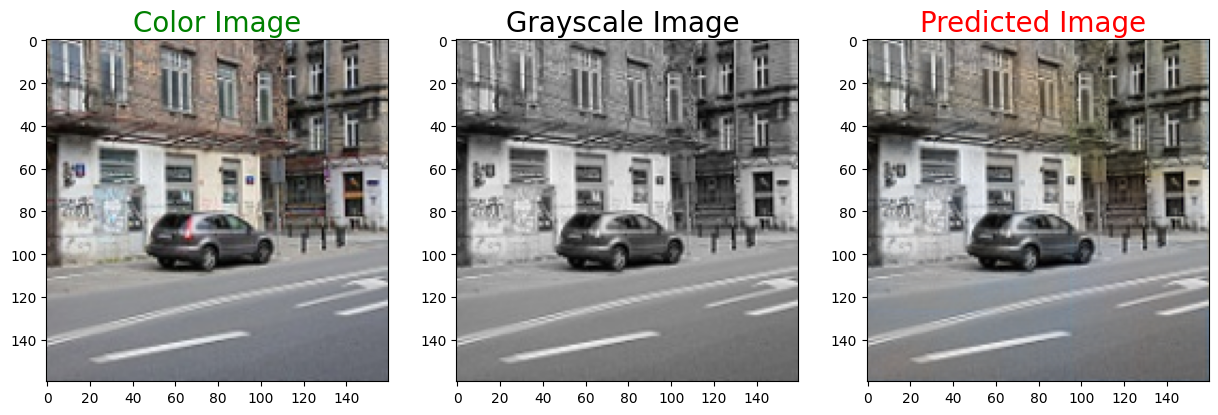

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


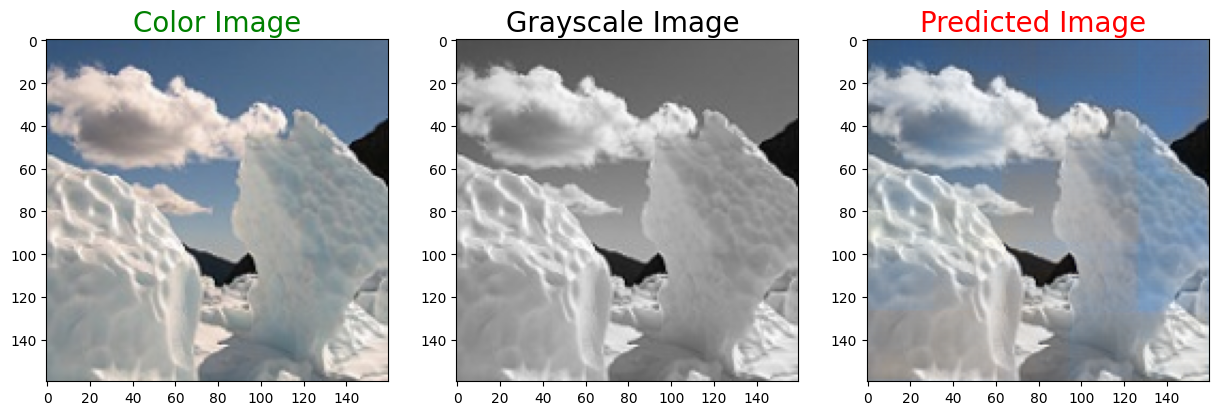

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


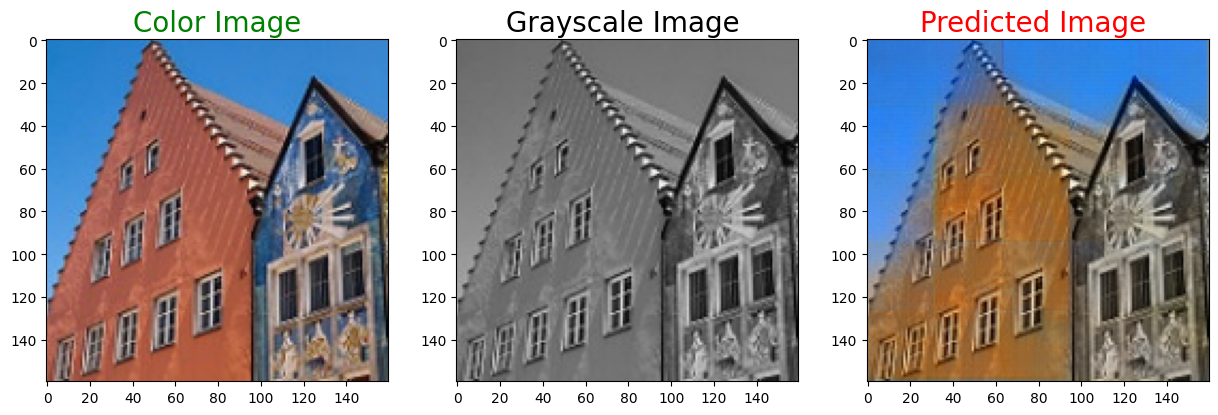

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


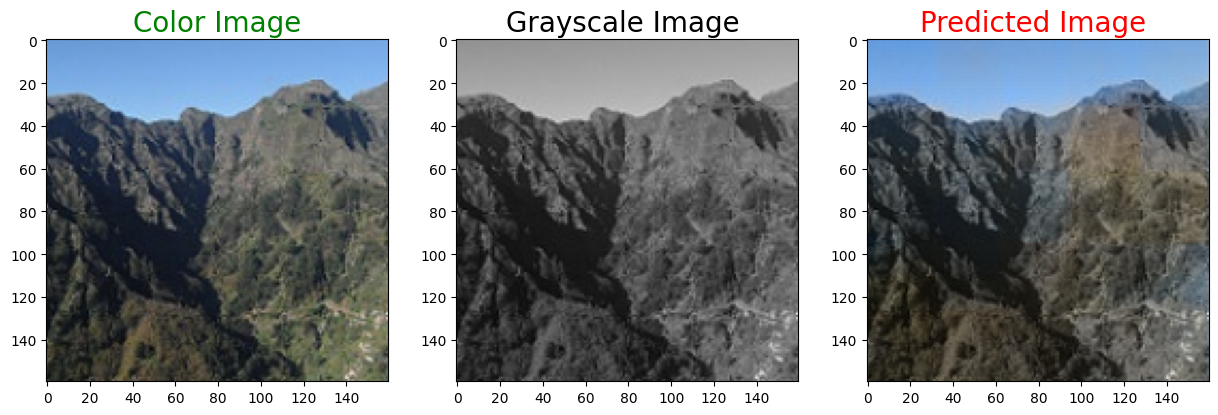

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


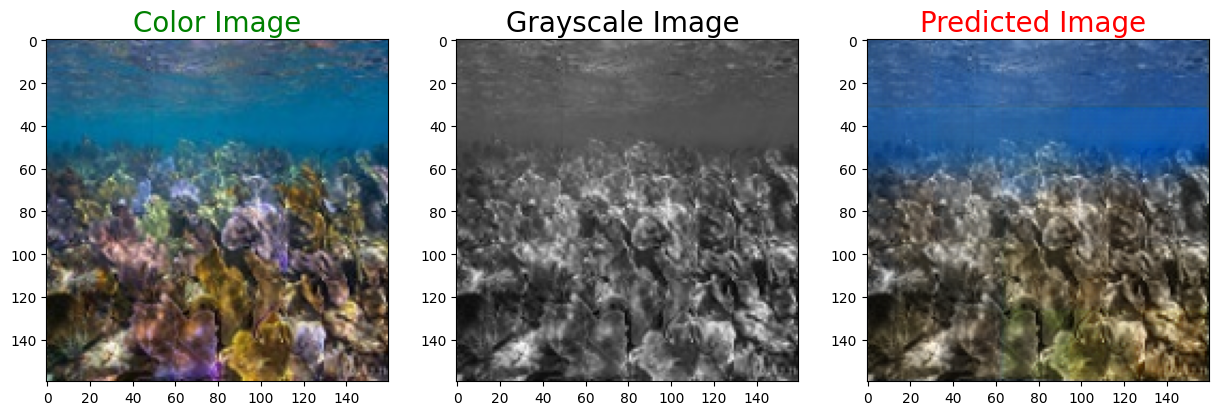

In [ ]:
# [8]. This section is used to give the comparison between color,grayscale,and predicted image
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [ ]:
# [9]. This section is used to Save the model, which is very important step.
model.save('pseudo_coloring_autoencoder.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('pseudo_coloring_autoencoder.h5')

In [ ]:
# [10]. This section is used to perform model on an unseen image to know it's performance.
import cv2
import numpy as np

# Load and preprocess the grayscale image
image_path = '/content/girl_gray_image.jfif'  # Update with the path of your grayscale image
SIZE = 160  # Image size used in training

# Read the grayscale image
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
gray_image = cv2.resize(gray_image, (SIZE, SIZE))
gray_image = gray_image.astype('float32') / 255.0
gray_image = np.stack((gray_image,)*3, axis=-1)  # Convert to 3 channels if required by the model
gray_image = np.expand_dims(gray_image, axis=0)  # Add batch dimension

In [ ]:
# Generate the colorized image
predicted_color_image = model.predict(gray_image)
predicted_color_image = np.clip(predicted_color_image[0], 0.0, 1.0)  # Remove batch dimension and clip values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


In [ ]:
# [11]. This section will provide result on an unseen image.
import matplotlib.pyplot as plt

# Display the original grayscale and predicted color image
plt.figure(figsize=(10, 5))

# Original grayscale image
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(gray_image[0], cmap="gray")

# Predicted colorized image
plt.subplot(1, 2, 2)
plt.title("Colorized Image")
plt.imshow(predicted_color_image)

plt.show()